# La predizione bayesiana {#sec-bayesian_prediction}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os
import logging

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# Configuration
seed = sum(map(ord, "stan_prediction"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

In questo capitolo esamineremo in dettaglio le distribuzioni predittive a priori e a posteriori. La distribuzione predittiva a priori rappresenta le aspettative sui dati prima di qualsiasi osservazione reale, riflettendo le conoscenze preesistenti e le ipotesi sui parametri del modello. Essa fornisce un'indicazione delle caratteristiche che i dati potrebbero assumere in base al modello. Confrontare queste previsioni con i dati effettivamente osservati consente di valutare la validità delle ipotesi incorporate nel modello.

La distribuzione predittiva è spesso di maggiore interesse rispetto alla distribuzione a posteriori. Mentre la distribuzione a posteriori descrive l'incertezza sui parametri (ad esempio, la proporzione di palline rosse in un'urna), la distribuzione predittiva descrive anche l'incertezza sugli eventi futuri (ad esempio, il colore della pallina che verrà estratta in futuro). Questa differenza è cruciale, soprattutto quando si tratta di prevedere gli effetti di un intervento, come la somministrazione di un trattamento a un paziente.

La distribuzione predittiva a posteriori è inoltre fondamentale per valutare quanto le previsioni del modello siano coerenti con i dati osservati. Se le previsioni del modello risultano allineate con i dati raccolti, il modello può essere considerato accurato nel rappresentare il processo generativo sottostante. Questo confronto è essenziale per convalidare il modello e assicurarsi che le ipotesi riflettano adeguatamente la realtà osservata.

## La distribuzione predittiva a posteriori {#sec-posterior-predictive-distribution}

La [distribuzione predittiva a posteriori](https://mc-stan.org/docs/stan-users-guide/posterior-predictive-checks.html#prior-predictive-checks) offre una valutazione critica della coerenza tra i dati reali e quelli simulati dal modello [@gelman2013philosophy]. Confrontando direttamente i dati osservati con quelli generati dal modello, essa permette di identificare eventuali discrepanze che potrebbero segnalare problemi nella specificazione del modello. In pratica, la PPC (Posterior Predictive Check) funge da test diagnostico, consentendo di rilevare e correggere eventuali carenze nel modello, migliorandone così le capacità predittive.

Per comprendere meglio il concetto, consideriamo la distribuzione predittiva a posteriori in termini di un modello coniugato normale-normale. Supponiamo di voler predire la media di una distribuzione normale futura, basandoci sui dati osservati e sulle nostre conoscenze a priori. La PPD ci offre uno strumento per calcolare queste probabilità, combinando le informazioni provenienti dai dati osservati con quelle fornite dalla distribuzione a priori.

Ad esempio, immaginiamo di aver raccolto dati sulle altezze di 100 persone, ottenendo una media campionaria di 170 cm e una deviazione standard campionaria di 10 cm. Il nostro obiettivo è stimare la media delle altezze in un futuro campione di $n=100$ persone. La nostra conoscenza a priori sulla media delle altezze è rappresentata da una distribuzione normale con media 175 cm e deviazione standard di 5 cm. 

In termini di notazione, possiamo esprimere questa distribuzione come $P(\tilde{y}|\theta=\theta_1)$, dove $\tilde{y}$ rappresenta un nuovo dato che è diverso dai dati attuali $y$, e $\theta_1$ è la media a posteriori. Tuttavia, in statistica bayesiana, è fondamentale incorporare tutta l'incertezza nei risultati. Poiché $\theta_1$ è solo uno dei possibili valori per $\theta$, dovremmo includere ogni valore di $\theta$ per la nostra previsione. Per ottenere la migliore previsione, possiamo "mediare" le previsioni attraverso i diversi valori di $\theta$, ponderando ciascun valore secondo la sua probabilità a posteriori.

La distribuzione risultante è la distribuzione predittiva a posteriori, che in notazione matematica è data da:

$$ P(\tilde{y}|y) = \int_\theta p(\tilde{y}|\theta, y) p(\theta|y) d\theta. $$

In questo modo, la distribuzione predittiva a posteriori combina le informazioni dai dati osservati con la conoscenza a priori, fornendo una previsione che riflette l'incertezza associata a tutti i possibili valori dei parametri del modello.

## Distribuzione predittiva a posteriori nel modello normale-normale

Nel modello coniugato normale-normale, se i dati osservati $Y = \{y_1, y_2, ..., y_n\}$ sono modellati come provenienti da una distribuzione normale con media $\mu$ e varianza $\sigma^2$, e assumendo una distribuzione a priori normale per $\mu$, la distribuzione a posteriori di $\mu$ sarà anch'essa normale.

### Formule della distribuzione predittiva a posteriori

Dato che:

1. I dati osservati $y_i \sim \mathcal{N}(\mu, \sigma^2)$
2. La prior per $\mu$ è $\mu \sim \mathcal{N}(\mu_0, \tau_0^2)$

La distribuzione a posteriori per $\mu$ sarà:

$$
\mu \mid Y \sim \mathcal{N}(\mu_n, \tau_n^2)
$$

dove:

$$
\mu_n = \frac{\tau_0^2 \bar{y} + \sigma^2 \mu_0}{\tau_0^2 + \sigma^2}
$$

e

$$
\tau_n^2 = \frac{\tau_0^2 \sigma^2}{\tau_0^2 + \sigma^2}
$$

Qui, $\bar{y}$ è la media campionaria dei dati osservati.

::: {#exm-}

Consideriamo che:

- $\mu_0 = 175$ cm (media a priori)
- $\tau_0 = 5$ cm (deviazione standard a priori)
- $\bar{y} = 170$ cm (media campionaria)
- $\sigma = 10$ cm (deviazione standard campionaria)
- $n = 100$ (numero di osservazioni)

I parametri della distribuzione a posteriori sono:

$$
\mu_n = \frac{(5^2 \cdot 170) + (10^2 \cdot 175)}{5^2 + 10^2} = \frac{42500 + 175000}{25 + 100} = \frac{217500}{125} = 174 \quad \text{cm}
$$

$$
\tau_n^2 = \frac{5^2 \cdot 10^2}{5^2 + 10^2} = \frac{2500}{125} = 20 \quad \text{cm}^2 \Rightarrow \tau_n = \sqrt{20} \approx 4.47 \quad \text{cm}
$$

Pertanto, la distribuzione a posteriori per $\mu$ è:

$$
\mu \mid Y \sim \mathcal{N}(174, 4.47^2)
$$

Per la distribuzione predittiva a posteriori, dobbiamo considerare anche la varianza della distribuzione futura. Se stiamo predicendo per $n_{\text{fut}}=100$ nuove osservazioni, la varianza della media predittiva sarà:

$$
\sigma_{\text{pred}}^2 = \tau_n^2 + \frac{\sigma^2}{n_{\text{fut}}}
$$

$$
\sigma_{\text{pred}}^2 = 20 + \frac{10^2}{100} = 20 + 1 = 21 \quad \text{cm}^2 \Rightarrow \sigma_{\text{pred}} = \sqrt{21} \approx 4.58 \quad \text{cm}
$$

Quindi, la distribuzione predittiva a posteriori è:

$$
\tilde{Y} \sim \mathcal{N}(174, 4.58^2)
$$

:::

## Implementazione con cmdstanpy

Per illustrare come viene generata la distribuzione predittiva a posteriori nel contesto del modello normale-normale, possiamo utilizzare `cmdstanpy` per eseguire l'analisi. Il codice seguente mostra come configurare il modello e generare previsioni.

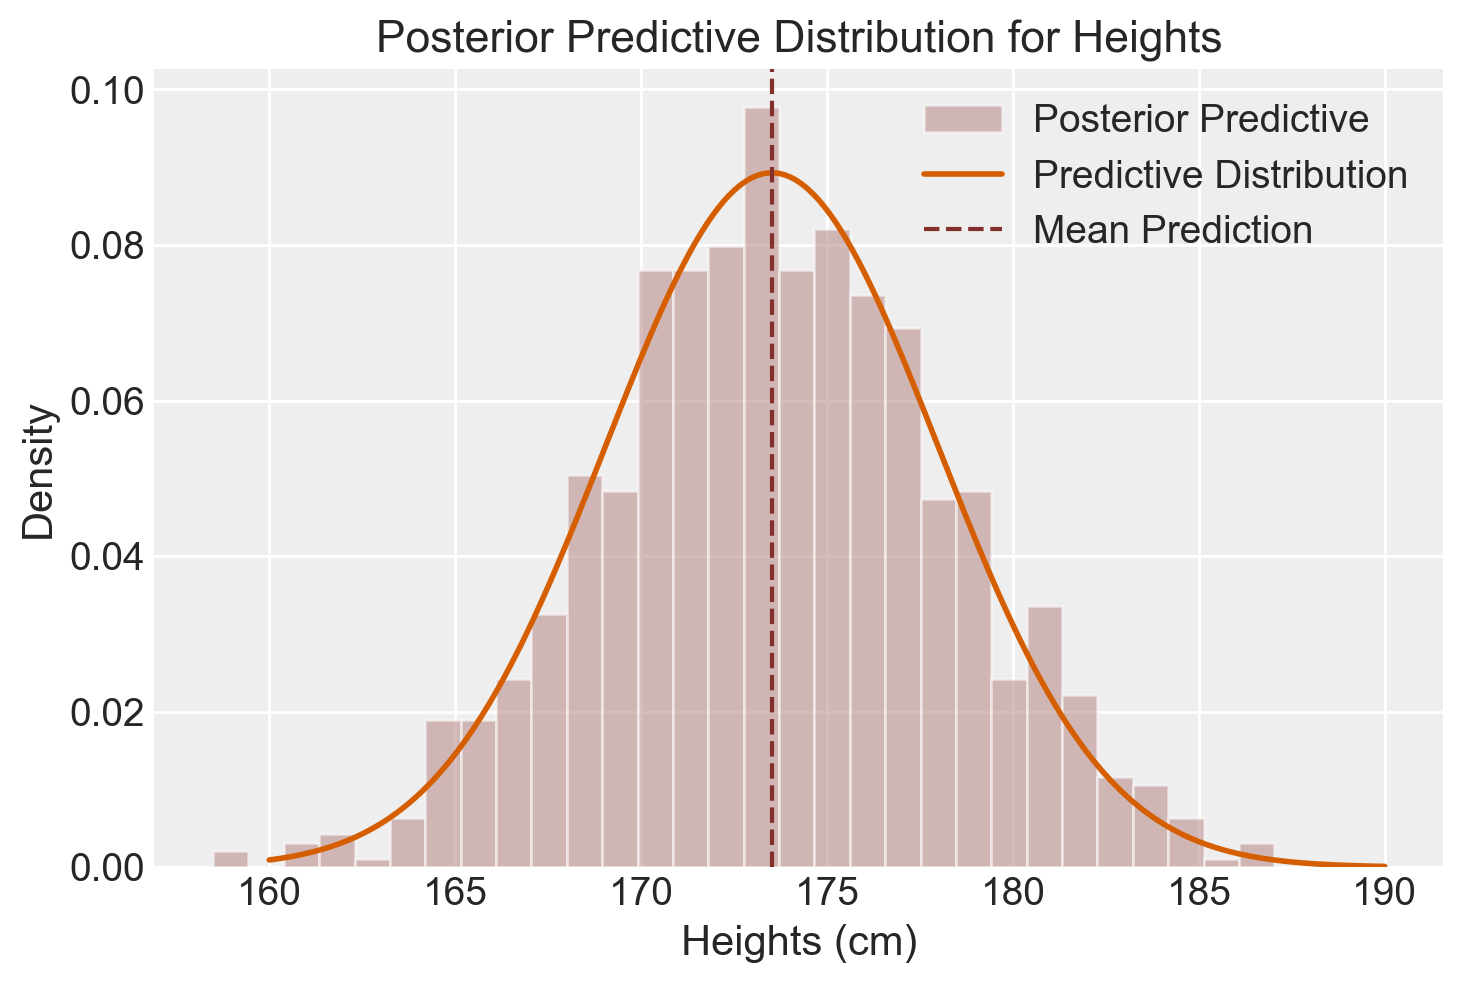

In [4]:
# Dati osservati
y_observed = np.random.normal(170, 10, 100)
mean_y = np.mean(y_observed)
std_y = np.std(y_observed)

# Parametri a priori
mu_0 = 175
tau_0 = 5

# Parametri posteriori
tau_n_sq = (tau_0**2 * std_y**2) / (tau_0**2 + std_y**2)
tau_n = np.sqrt(tau_n_sq)
mu_n = (tau_0**2 * mean_y + std_y**2 * mu_0) / (tau_0**2 + std_y**2)

# Parametri predittivi
n_fut = 100
sigma_pred_sq = tau_n_sq + (std_y**2 / n_fut)
sigma_pred = np.sqrt(sigma_pred_sq)
mu_pred = mu_n

# Simulazioni
y_pred_samples = np.random.normal(mu_pred, sigma_pred, 1000)

color_fill = "#B17F7D"
color_edge = "#832F2B"

# Grafico
plt.hist(y_pred_samples, bins=30, density=True, color=color_fill, alpha=0.5, label='Posterior Predictive')
x = np.linspace(160, 190, 200)
plt.plot(x, stats.norm.pdf(x, mu_pred, sigma_pred), 'r-', lw=2, label='Predictive Distribution')
plt.axvline(x=mu_pred, color=color_edge, linestyle='--', label='Mean Prediction')
plt.xlabel('Heights (cm)')
plt.ylabel('Density')
plt.title('Posterior Predictive Distribution for Heights')
plt.legend()
plt.show()

Questo codice produce un grafico che illustra visivamente la distribuzione predittiva a posteriori per le altezze nel nostro campione di 100 nuove osservazioni, tenendo conto sia dei dati osservati che delle nostre aspettative iniziali.

In sintesi, la distribuzione predittiva a posteriori è stata generata nel modo seguente:

1. Campioniamo un valore $\mu$ dalla distribuzione a posteriori di $\mu$.
2. Campioniamo un valore $\sigma$ dalla distribuzione a posteriori di $\sigma$.
3. Utilizziamo questi valori per generare un campione dalla distribuzione normale con parametri $\mu$ e $\sigma$.
4. Ripetiamo questo processo molte volte.

La distribuzione dei valori ottenuti da questi campionamenti costituisce la distribuzione predittiva a posteriori.

## Metodo MCMC

Quando usiamo un PPL come Stan, la distribuzione predittiva viene stimata mediante il campionamento da una catena di Markov, che è particolarmente utile in scenari complessi dove l'analisi analitica potrebbe essere impraticabile. Attraverso i metodi MCMC, si stimano le potenziali osservazioni future $p(\tilde{y} \mid y)$, indicate come $p(y^{rep} \mid y)$, seguendo questi passaggi:

1. Si campiona $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro (o dei parametri) dalla distribuzione a posteriori.
2. Si campiona $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene scelta casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro (o dei parametri)ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. 

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con Stan per i dati dell'esempio precedente. Iniziamo creando le distribuzioni a posteriori di $\mu$ e $\sigma$.

In [6]:
stan_ncp_file = os.path.join(
    project_directory, 'stan', 'gaussian_model.stan')
model_ncp = CmdStanModel(stan_file=stan_ncp_file)
print(model_ncp.code())

data {
  int<lower=0> N; // number of observations
  vector[N] y; // observed data
  real mu_prior; // prior mean for mu
  real<lower=0> sigma_prior; // prior standard deviation for mu
  real<lower=0> sigma_prior_mean; // prior mean for sigma
  real<lower=0> sigma_prior_sd; // prior standard deviation for sigma
}
parameters {
  real mu; // parameter of interest
  real<lower=0> sigma; // parameter for the standard deviation
}
model {
  mu ~ normal(mu_prior, sigma_prior); // prior for mu
  sigma ~ normal(sigma_prior_mean, sigma_prior_sd); // prior for sigma
  y ~ normal(mu, sigma); // likelihood
}
generated quantities {
  array[N] real y_rep;
  for (n in 1 : N) {
    y_rep[n] = normal_rng(mu, sigma);
  }
}



Definiamo un dizionario che contiene i dati.

In [7]:
stan_data = {
    'N': len(y_observed), 
    'y': y_observed,
    'mu_prior': 180,
    'sigma_prior': 20,
    'sigma_prior_mean': 10,
    'sigma_prior_sd': 3
}

print(stan_data)

{'N': 100, 'y': array([157.2160102 , 162.69486738, 162.68308386, 164.27686592,
       186.47491897, 161.39538834, 172.38571153, 184.63747656,
       162.19119191, 170.19037732, 179.11386969, 164.55377485,
       156.00523753, 172.82193962, 173.16471363, 164.63937533,
       169.53511461, 178.1479531 , 175.49566912, 176.36456333,
       180.81434309, 171.67280359, 159.36318605, 158.03513125,
       151.76028503, 153.00047577, 171.88750707, 167.85311897,
       177.083167  , 177.281136  , 180.09209358, 174.45888609,
       168.16538298, 171.52283409, 159.34294043, 179.92208416,
       176.76991899, 164.05355475, 167.44625251, 189.01908606,
       169.88195177, 170.15351338, 168.4609556 , 163.39960566,
       162.57875308, 177.18609527, 169.40757495, 170.89843378,
       160.63985555, 167.92153439, 185.87271602, 172.97707565,
       175.4461066 , 171.49878753, 163.44978271, 172.61501383,
       163.13413454, 165.37487144, 165.2944901 , 151.44770452,
       162.76871876, 174.95310706, 171.

In [5]:
y_mean = np.mean(y_observed)
y_std = np.std(y_observed)

print(f"Mean of y: {y_mean}")
print(f"Standard Deviation of y: {y_std}")

Mean of y: 169.57193226941754
Standard Deviation of y: 9.930634097490112


Eseguiamo il campionamento MCMC:

In [6]:
trace_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

16:57:29 - cmdstanpy - INFO - CmdStan start processing
16:57:29 - cmdstanpy - INFO - Chain [1] start processing
16:57:29 - cmdstanpy - INFO - Chain [2] start processing
16:57:29 - cmdstanpy - INFO - Chain [3] start processing
16:57:29 - cmdstanpy - INFO - Chain [4] start processing
16:57:29 - cmdstanpy - INFO - Chain [1] done processing
16:57:29 - cmdstanpy - INFO - Chain [2] done processing
16:57:29 - cmdstanpy - INFO - Chain [3] done processing
16:57:29 - cmdstanpy - INFO - Chain [4] done processing


Un sommario delle distribuzioni a posteriori dei parametri si ottiene nel modo seguente:

In [7]:
az.summary(trace_ncp, var_names=['mu', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,169.62,1.00,167.73,171.43,0.01,0.01,6155.68,5203.68,1.0
sigma,10.09,0.71,8.69,11.35,0.01,0.01,7169.12,5070.39,1.0


Convertiamo l'oggetto `sample_ncp` in un oggetto di classe InferenceData:

In [8]:
idata = az.from_cmdstanpy(
    posterior=trace_ncp, 
    posterior_predictive='y_rep', 
    observed_data={"y": y_observed}
)

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

Possiamo ora usare ArviZ per generare il posterior-predictive plot:

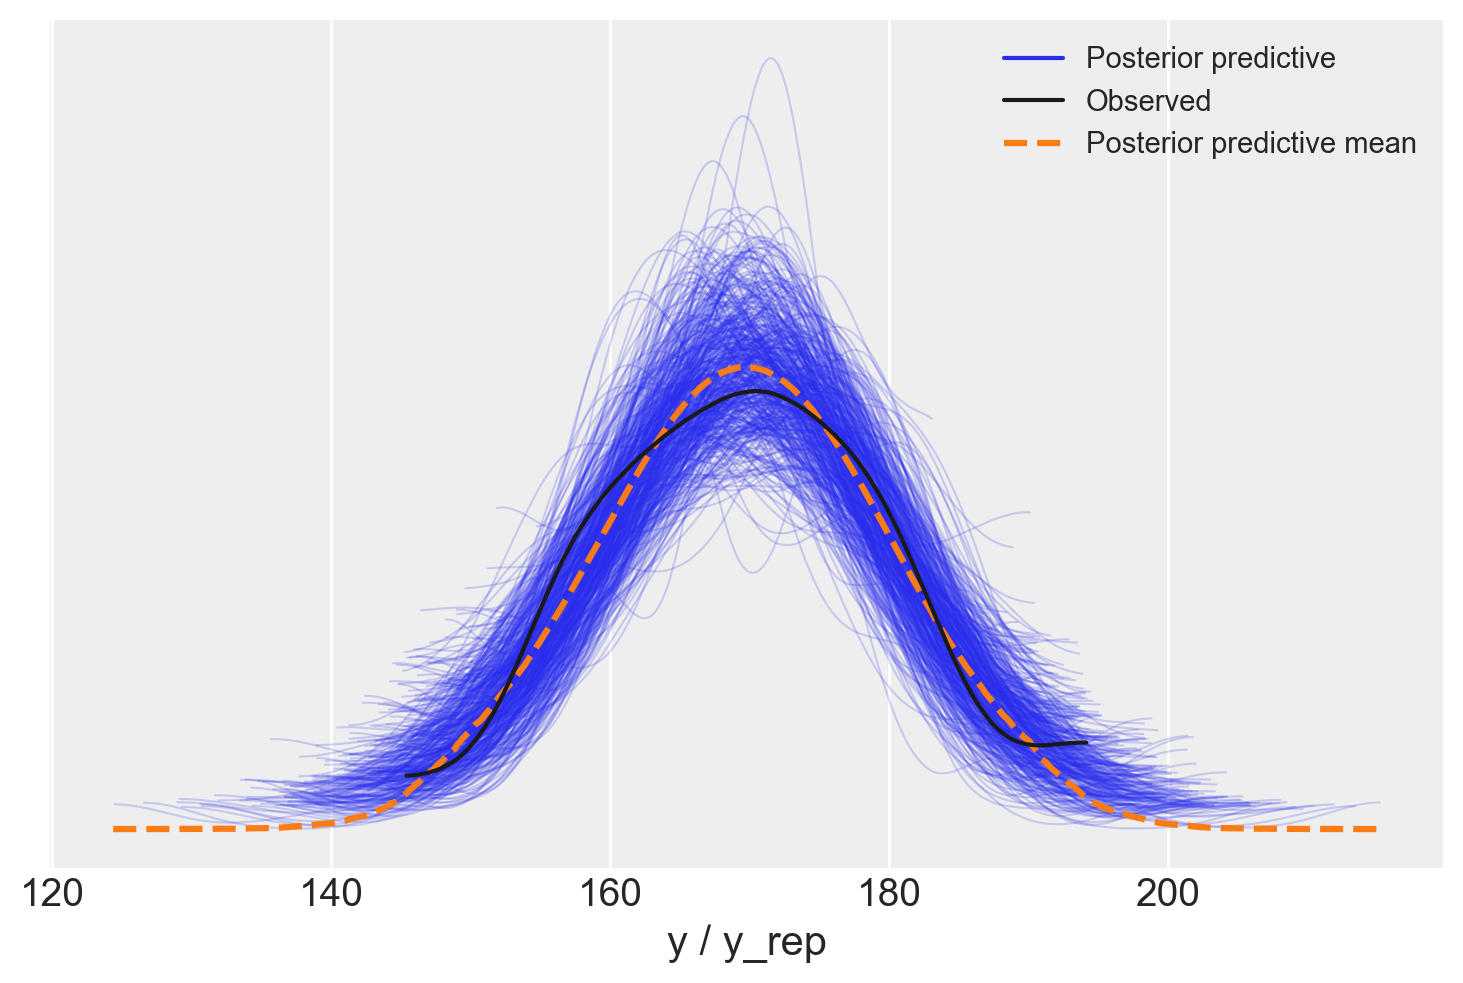

In [9]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

## Distribuzione Predittiva a Priori

Le [verifiche predittive a priori](https://mc-stan.org/docs/stan-users-guide/posterior-predictive-checks.html#prior-predictive-checks) generano dati utilizzando unicamente le distribuzioni a priori, ignorando i dati osservati, al fine di valutare se tali distribuzioni a priori sono appropriate. La distribuzione predittiva a priori è quindi simile alla distribuzione predittiva a posteriori, ma senza dati osservati, rappresentando il caso limite di una verifica predittiva a posteriori senza dati.

Questo processo può essere realizzato facilmente simulando i parametri secondo le distribuzioni a priori e poi simulando i dati in base al modello dati i parametri simulati. Il risultato è una  simulazione dalla distribuzione predittiva a priori.

Questa procedura è fondamentale per verificare se le ipotesi a priori sono realistiche e adeguate prima di raccogliere o utilizzare i dati osservati. Se i dati simulati dalla distribuzione predittiva a priori non risultano plausibili, potrebbe essere necessario rivedere le scelte delle distribuzioni a priori.

Un *prior predictive check* è codificato come un *posterior predictive check*. Se disponiamo già del codice per un posterior predictive check ed è possibile impostare i dati come vuoti, allora non è necessario alcun codice ulteriore. I *prior predictive checks* possono essere codificati interamente all'interno del blocco `generated quantities` utilizzando la generazione di numeri casuali. I draw risultanti saranno indipendenti. 

::: {#exm-}

Consideriamo un primo esempio pratico utilizzando il modello beta-binomiale. Il modello iniziale, che include il blocco `model`, serve per stimare i parametri del modello sulla base dei dati osservati.

```stan
data {
  int<lower=0> N;
  array[N] int<lower=0, upper=1> y;
  int<lower=0> alpha_prior;
  int<lower=0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior);
  y ~ bernoulli(theta);
}
```

Per ottenere un campione dalla distribuzione *a priori* (cioè prima di osservare i dati), possiamo modificare il modello come segue:

```stan
data {
  int<lower=0> N;  // Numero di osservazioni
  int<lower=0> alpha_prior;  // Parametro di forma della distribuzione beta a priori
  int<lower=0> beta_prior;  // Parametro di forma della distribuzione beta a priori
}
generated quantities {
  array[N] int y_sim;  // Dati simulati
  real<lower=0, upper=1> theta_prior;  // Valore di theta estratto dalla distribuzione a priori

  // Estraiamo un valore per theta dalla distribuzione beta a priori
  theta_prior = beta_rng(alpha_prior, beta_prior);

  // Simuliamo N osservazioni dalla distribuzione binomiale
  // utilizzando il valore di theta estratto e il numero totale di osservazioni N
  for (n in 1:N)
    y_sim[n] = binomial_rng(N, theta_prior);
}
```

In questo secondo script abbiamo

* *eliminato il blocco `model`:* Questo blocco serve per l'inferenza Bayesiana, ma non è necessario per generare dati a priori.
* *aggiunto il blocco `generated quantities`:* In questo blocco generiamo quantità di interesse, come i dati simulati `y_sim` e il valore di `theta` estratto dalla distribuzione a priori.
* *utilizzato la funzione `beta_rng`* per estrarre un valore per `theta` dalla distribuzione $\mathcal{Beta}$ definita dai parametri `alpha_prior` e `beta_prior`. Questo valore rappresenta una possibile realizzazione del parametro prima di osservare i dati.
* *utilizzato la funzione `binomial_rng`* per simulare `N` osservazioni dalla distribuzione binomiale. Il parametro di successo `theta` è fissato al valore estratto `theta_prior`.

In sostanza, questo codice ci permette di generare un dataset simulato che potrebbe essere osservato se il processo stocastico fosse governato unicamente dai parametri specificati nella distribuzione a priori. In questo modo, possiamo valutare le proprietà del modello e la sua capacità di generare dati simili a quelli reali, prima ancora di avere a disposizione i dati osservati.

La distribuzione a priori rappresenta la nostra conoscenza o credenza sul valore del parametro `theta` prima di osservare i dati. Scegliendo diversi valori per `alpha_prior` e `beta_prior`, possiamo specificare diverse distribuzioni a priori e quindi esplorare come queste influenzano i risultati della simulazione.

In [38]:
stan_file = os.path.join(project_directory, "stan", "beta_binomial_prior.stan")
model_beta_binomial_prior = CmdStanModel(stan_file=stan_file)
print(model_beta_binomial_prior.code())

data {
  int<lower=0> N;
  real<lower=0> alpha_prior;
  real<lower=0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  // Definizione del priore Beta
  theta ~ beta(alpha_prior, beta_prior);
}
generated quantities {
  // Generazione della distribuzione predittiva a priori
  array[N] int<lower=0, upper=1> y_sim;
  for (n in 1 : N) {
    y_sim[n] = bernoulli_rng(theta);
  }
}



Creiamo il dizionario Stan per il caso dell'esempio in discussione.

In [39]:
N = 100
y = 14

# Create an integer array of zeros
y_vec = np.zeros(N, dtype=np.int32)

# Assign 1 to the first y elements
y_vec[:y] = 1

alpha_prior = 4
beta_prior = 6

stan_data = {
    "N": N,
    "y": y_vec,
    "alpha_prior": alpha_prior,
    "beta_prior": beta_prior,
}

Eseguiamo il campionamento.

In [59]:
pp_samples = model_beta_binomial_prior.sample(
    data=stan_data,
    iter_sampling=1000,
    iter_warmup=0,  # Un numero adeguato di iterazioni di warmup
    adapt_engaged=False,  # Disabilita l'adattamento
    chains=1,
    show_progress=False,
    show_console=False,
)

Dall'oggetto `pp_samples` estraiamo `y_sim`.

In [60]:
y_sim_samples = pp_samples.stan_variable("y_sim")
y_sim_flattened = y_sim_samples.flatten()

Calcoliamo le statistiche descrittive per i valori `y_sim` che abbiamo ottenuto.

In [61]:
y_rep_mean = np.mean(y_sim_flattened)
y_rep_std = np.std(y_sim_flattened)

print(f"Mean of y_rep: {y_rep_mean}")
print(f"Standard Deviation of y_rep: {y_rep_std}")

Mean of y_rep: 0.40553
Standard Deviation of y_rep: 0.49099431676955296


Generiamo una rappresentazione grafica della distribuzione di `y_sim`.

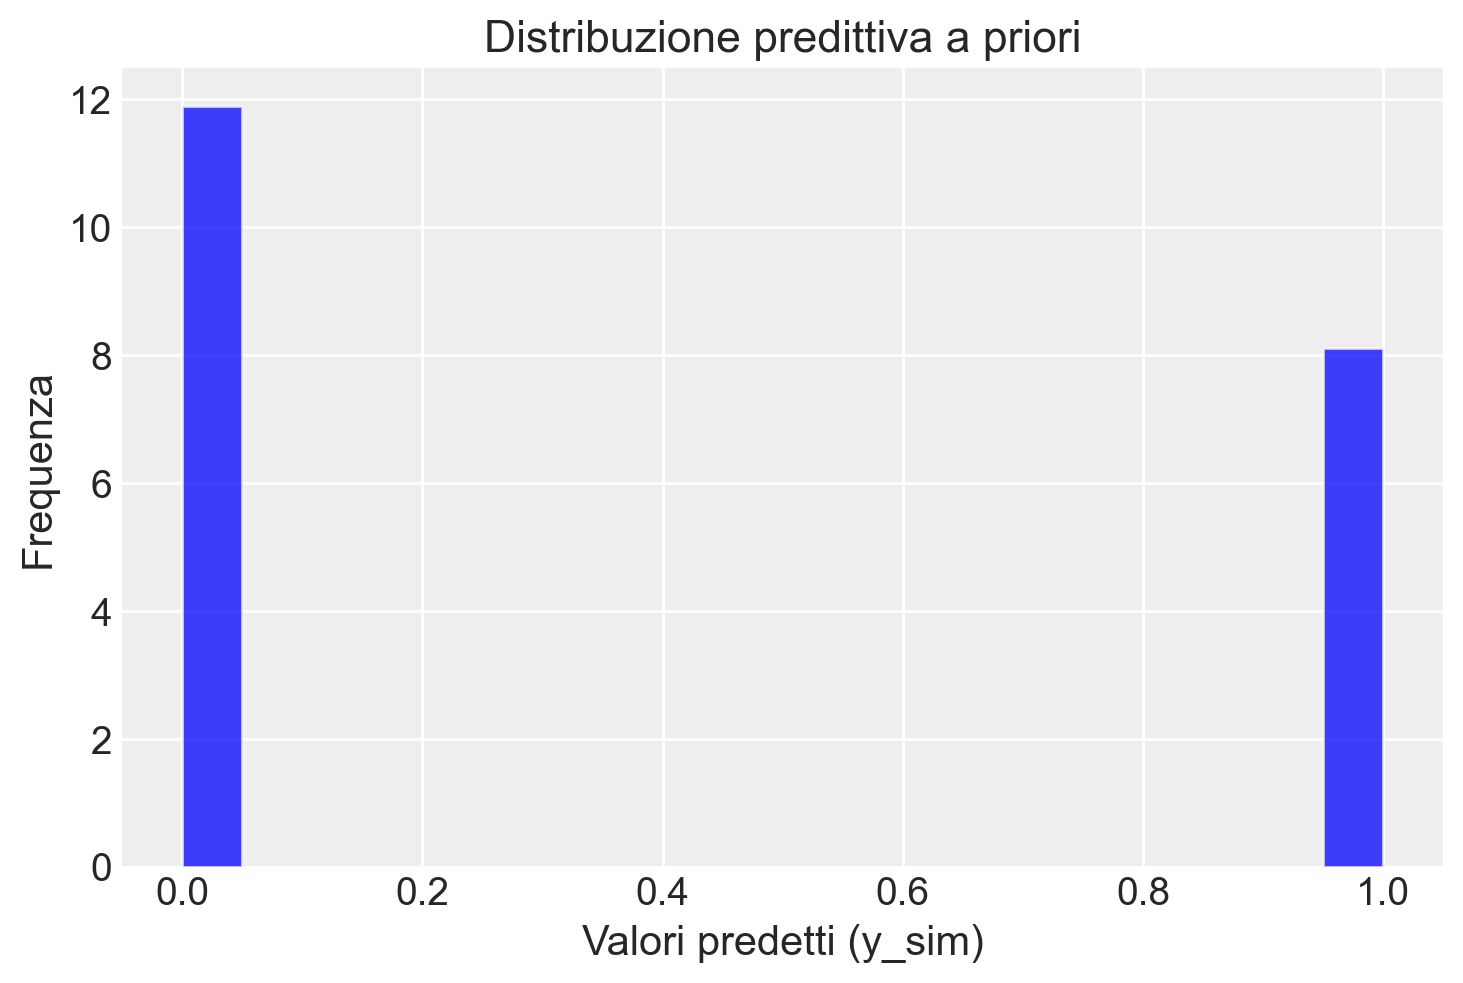

In [62]:
plt.hist(y_sim_flattened, bins=20, density=True, alpha=0.75, color="blue")
plt.title("Distribuzione predittiva a priori")
plt.xlabel("Valori predetti (y_sim)")
plt.ylabel("Frequenza")
plt.show()

Estraiamo i valori `theta` e generiamo un istogramma.

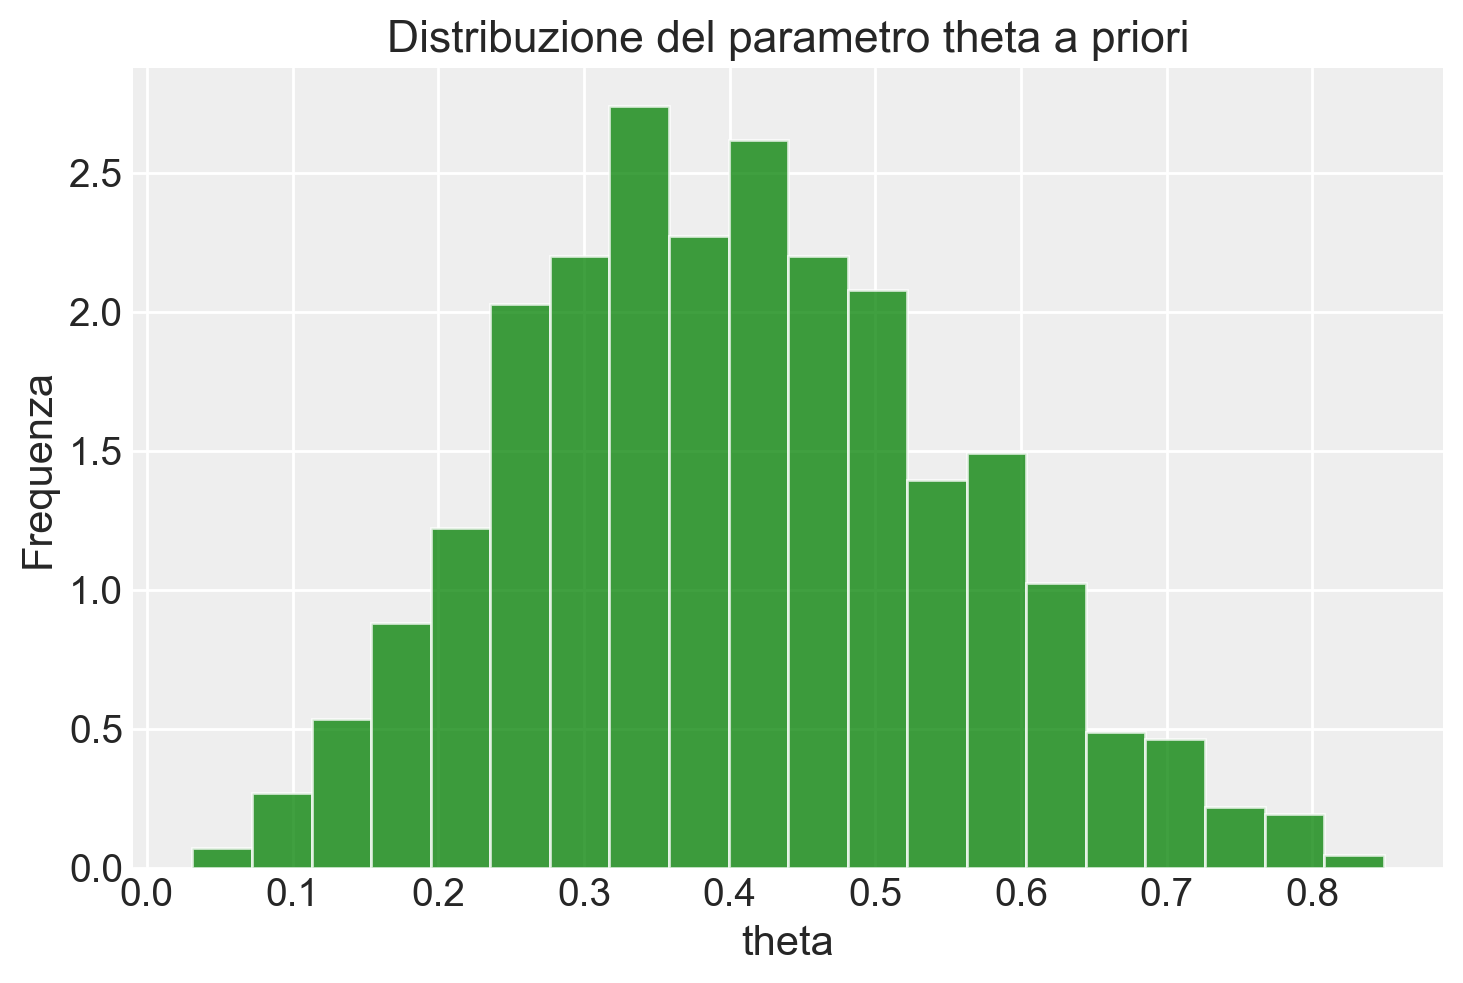

In [65]:
theta_samples = pp_samples.stan_variable("theta")
plt.hist(theta_samples, bins=20, density=True, alpha=0.75, color="green")
plt.title("Distribuzione del parametro theta a priori")
plt.xlabel("theta")
plt.ylabel("Frequenza")
plt.show()

Possiamo interpretare i risulati ottenuti nel modo seguente. In questo modello, stiamo utilizzando un prior $\mathcal{Beta}(4, 6)$ per il parametro $\theta$, che rappresenta la probabilità di successo in una distribuzione Bernoulliana. Questo prior riflette una convinzione a priori secondo la quale $\theta$ ha una media di $\frac{4}{4+6} = 0.4$, con una deviazione standard piuttosto ampia. Il risultato del prior predictive check mostra che la distribuzione simulata di successi ha una media di circa 0.405, con una deviazione standard di 0.491. 

Dato che nei dati reali abbiamo osservato 14 successi su 100 prove, corrispondenti a una proporzione di 0.14, il prior $\mathcal{Beta}(4, 6)$ risulta essere piuttosto largo e centrato su un valore di probabilità di successo notevolmente più alto rispetto ai dati osservati.

In conclusione,

- *Se abbiamo ragioni forti per imporre il prior $\mathcal{Beta}(4, 6)$*, ad esempio, una conoscenza precedente o una letteratura consolidata che suggerisce che la probabilità di successo dovrebbe aggirarsi attorno a 0.4, allora il prior predictive check conferma che il modello predittivo a priori si comporta come ci aspettiamo: il prior è informativo e impone un certo grado di convinzione sulla probabilità di successo. Questo significa che la nostra conoscenza a priori influenza fortemente il modello.

- *Se invece vogliamo imporre un prior debolmente informativo*, che permetta ai dati di avere un peso maggiore nell'inferenza, questo prior non è ideale. In questo caso, il prior $\mathcal{Beta}(4, 6)$ è troppo informativo, portando a una distribuzione predittiva a priori che è troppo concentrata intorno a 0.4 e non riflette adeguatamente la possibilità di avere proporzioni di successo più basse come quella osservata nei dati (0.14). Per un prior debolmente informativo, potremmo considerare un prior meno concentrato, come un $\mathcal{Beta}(2, 2)$, che lascia più spazio all'influenza dei dati osservati.

:::

::: {#exm-}

Consideriamo un secondo esempio, ovvero il caso discusso in precedenza di un campione di dati gaussiani e di un modello gaussiano in cui le distribuzioni a priori per μ e σ sono gaussiane.

In [2]:
stan_file = os.path.join(
    project_directory, 'stan', 'gaussian_model_prior.stan')
model_gauss = CmdStanModel(stan_file=stan_file)
print(model_gauss.code())

data {
  int<lower=0> N; // number of observations
  real mu_prior; // prior mean for mu
  real<lower=0> sigma_prior; // prior standard deviation for mu
  real<lower=0> sigma_prior_mean; // prior mean for sigma
  real<lower=0> sigma_prior_sd; // prior standard deviation for sigma
}
generated quantities {
  real mu = normal_rng(mu_prior, sigma_prior); // prior draw for mu
  real<lower=0> sigma = normal_rng(sigma_prior_mean, sigma_prior_sd); // prior draw for sigma
  array[N] real y_rep;
  for (n in 1 : N) {
    y_rep[n] = normal_rng(mu, sigma);
  }
}



Il codice precedente 

```stan
for (n in 1:N) {
    y_rep[n] = normal_rng(mu, sigma);
  }
```

illustra come generare campioni predittivi a priori nel blocco `generated quantities`. In questo esempio, `mu` e `sigma` sono generati dalle loro rispettive distribuzioni a priori e usati per generare campioni di dati simulati `y_rep`.

Eseguiamo il campionamento MCMC.

In [8]:
prior_predictive_samples = model_gauss.sample(
    data=stan_data, 
    fixed_param=True, 
    iter_sampling=1000, 
    iter_warmup=1, 
    chains=1,
    show_progress=False, 
    show_console=False
)

Estraiamo le variabili necessarie.

In [9]:
y_rep_samples = prior_predictive_samples.stan_variable("y_rep")
y_rep_flattened = y_rep_samples.flatten()

Calcoliamo le statistiche descrittive dei valori `y_rep`.

In [10]:
y_rep_mean = np.mean(y_rep_flattened)
y_rep_std = np.std(y_rep_flattened)

print(f'Mean of y_rep: {y_rep_mean}')
print(f'Standard Deviation of y_rep: {y_rep_std}')

Mean of y_rep: 179.84035606600006
Standard Deviation of y_rep: 23.17301041707538


Creiamo un KDE plot con la distribuzione predittiva a priori.

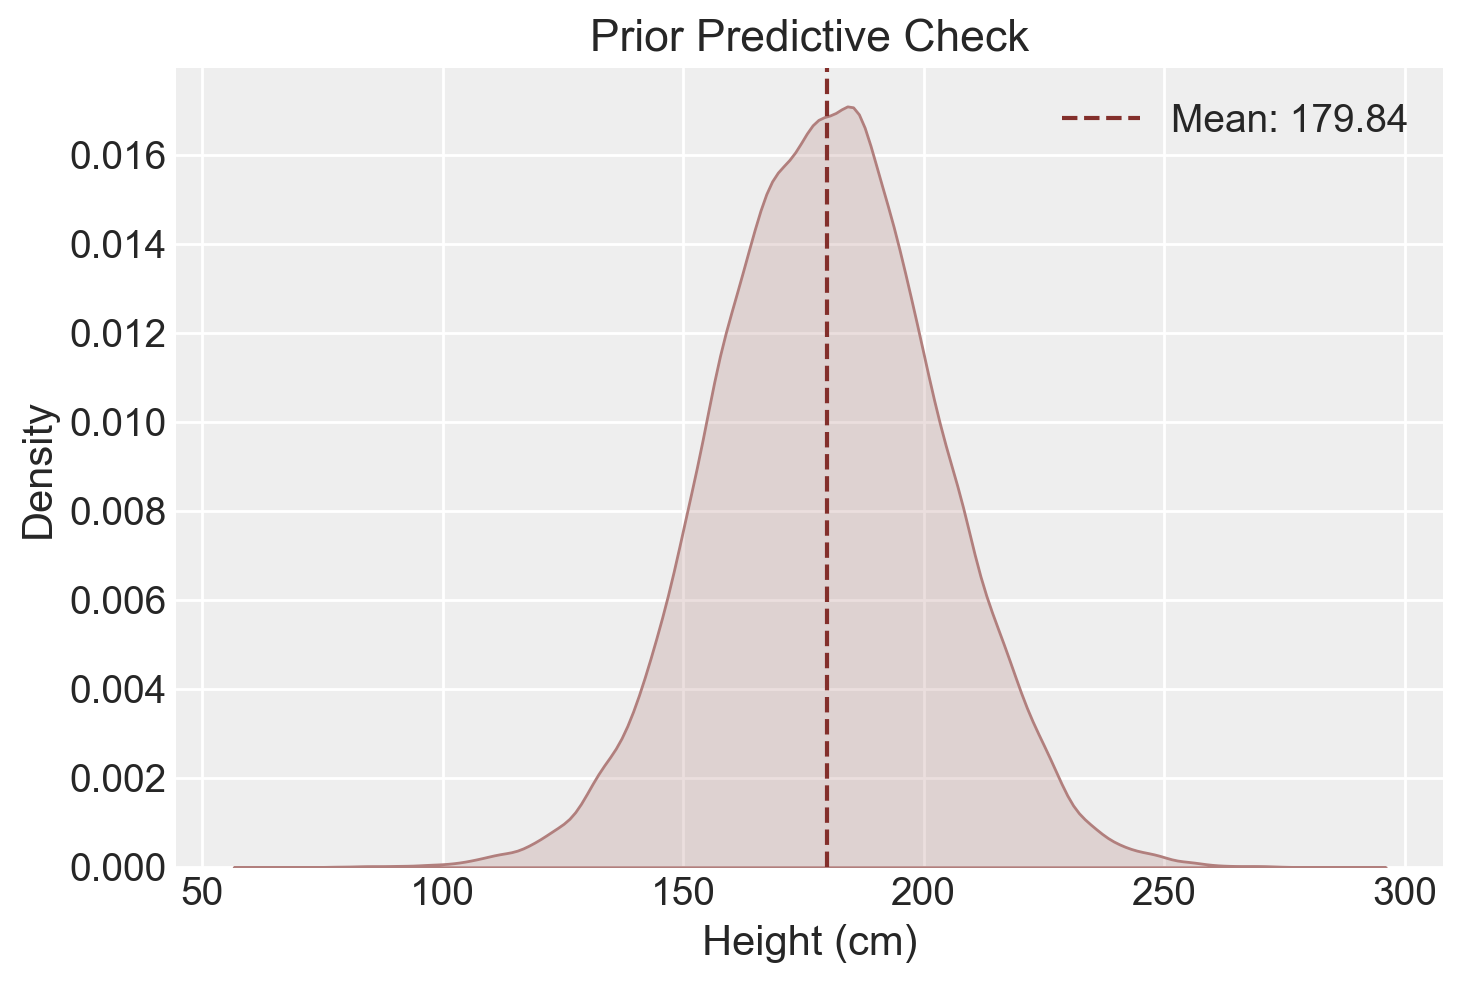

In [11]:
sns.kdeplot(y_rep_flattened, fill=True, color=color_fill)
plt.title('Prior Predictive Check')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.axvline(x=y_rep_mean, color=color_edge, linestyle='--', label=f'Mean: {y_rep_mean:.2f}')
plt.legend()
plt.show()

Il grafico della distribuzione predittiva a priori ci mostra che i prior utilizzati nel codice Stan implicano una distribuzione della variabile di interesse `y` che è approssimativamente normale con media di 180.25 e deviazione standard di 22.23. Questo *prior predictive check* garantisce che le distribuzioni a priori dei parametri `mu` e `sigma` siano realistiche e adeguate per l'analisi dei dati considerati. Questo passaggio consente di identificare e correggere eventuali ipotesi errate prima di procedere con l'analisi dei dati osservati, migliorando così la validità dei risultati ottenuti.

:::

## Considerazioni Conclusive

Le distribuzioni predittive a priori e a posteriori, pur essendo generate in modo simile, differiscono per la fonte di informazione utilizzata nella loro costruzione.

- **Distribuzione Predittiva a Priori**: Questa distribuzione rappresenta le nostre aspettative sui dati prima che qualsiasi osservazione effettiva sia disponibile. Per costruirla, prendiamo i valori dei parametri dalla distribuzione a priori e li utilizziamo nella funzione di verosimiglianza per generare dati simulati. La distribuzione risultante di questi dati generati è la distribuzione predittiva a priori, che riflette le nostre conoscenze e incertezze iniziali, prima di osservare i dati reali.

- **Distribuzione Predittiva a Posteriori**: Dopo aver osservato i dati, aggiorniamo le nostre credenze sui parametri utilizzando il teorema di Bayes, ottenendo così la distribuzione a posteriori dei parametri. La distribuzione predittiva a posteriori viene quindi generata prendendo valori dei parametri dalla distribuzione a posteriori, che ora incorpora l'informazione ottenuta dai dati osservati, e utilizzandoli nella funzione di verosimiglianza per generare nuovi dati simulati. Questa distribuzione riflette le nostre previsioni sui dati futuri o non osservati, dopo aver tenuto conto dei dati già raccolti.

La differenza principale tra queste due distribuzioni predittive risiede nella distribuzione dei parametri utilizzata: nella distribuzione predittiva a priori si utilizzano i parametri estratti dal prior, mentre nella distribuzione predittiva a posteriori si utilizzano i parametri estratti dal posterior. La distribuzione predittiva a posteriori è generalmente più informativa poiché integra i dati osservati, migliorando le previsioni future.

È cruciale per l'integrità del modello che la distribuzione predittiva a posteriori sia coerente con la distribuzione dei dati osservati. Per verificare questa coerenza, si utilizzano le verifiche predittive a posteriori, confrontando la distribuzione predittiva con i dati empirici tramite tecniche come le stime di densità kernel (KDE). Questo confronto permette di valutare quanto bene il modello riesca ad approssimare la struttura reale dei dati e la sua capacità di fornire previsioni affidabili.

Ad esempio, consideriamo un modello gaussiano con varianza $\sigma^2$ nota:

$$
\begin{aligned}
  y\sim \mathop{\mathrm{N}}(\theta,\sigma^2),
\end{aligned}
$$

dove $\sigma^2$ descrive l'incertezza aleatoria. Usando un prior uniforme, la distribuzione a posteriori per $\theta$ sarà:

$$
\begin{aligned}
  p(\theta|y) \sim \mathop{\mathrm{N}}(\theta|\bar{y},\sigma^2/n),
\end{aligned}
$$

dove $\sigma^2/n$ rappresenta l'incertezza epistemica legata a $\theta$. La distribuzione predittiva a posteriori per un nuovo valore $\tilde{y}$ sarà:

$$
\begin{aligned}
  p(\tilde{y}|y) \sim \mathop{\mathrm{N}}(\tilde{y}|\bar{y},\sigma^2+\sigma^2/n),
\end{aligned}
$$

In questo caso, l'incertezza totale è data dalla somma dell'incertezza epistemica ($\sigma^2/n$) e dell'incertezza aleatoria ($\sigma^2$).

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Sun Aug 04 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
arviz     : 0.18.0
scipy     : 1.14.0
pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.1

Watermark: 2.4.3

